In [14]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

import matplotlib.pyplot as plt
import roadrunner
import numpy as np
import pandas as pd

## Create an example Model

In [2]:
model = ModelBuilder('SimpleCascade')

A_species = ['A0', 'A1']
B_species = ['B0', 'B1']
C_species = ['C']

for specie in A_species:
    model.add_reaction(Reaction(michaelis_menten, (specie+'p',), (specie,)))
    model.add_reaction(Reaction(michaelis_menten, (specie,), (specie+'p',)))

for specie in B_species:
    model.add_reaction(Reaction(michaelis_menten_stim, (specie+'p',), (specie,), extra_states=('A'+specie[1]+'p',)))
    model.add_reaction(Reaction(michaelis_menten, (specie,), (specie+'p',)))
    
for specie in C_species:
    model.add_reaction(Reaction(michaelis_menten, (specie+'p',), (specie,)))
    model.add_reaction(Reaction(michaelis_menten, (specie,), (specie+'p',)))
    
# add stimulation reactions

print(model.get_antimony_model())

model SimpleCascade

J0: A0p -> A0; J0_Vmax*A0p/(J0_Km + A0p)
J1: A0 -> A0p; J1_Vmax*A0/(J1_Km + A0)
J2: A1p -> A1; J2_Vmax*A1p/(J2_Km + A1p)
J3: A1 -> A1p; J3_Vmax*A1/(J3_Km + A1)
J4: B0p -> B0; J4_Vmax*B0p*A0p/(J4_Km + B0p)
J5: B0 -> B0p; J5_Vmax*B0/(J5_Km + B0)
J6: B1p -> B1; J6_Vmax*B1p*A1p/(J6_Km + B1p)
J7: B1 -> B1p; J7_Vmax*B1/(J7_Km + B1)
J8: Cp -> C; J8_Vmax*Cp/(J8_Km + Cp)
J9: C -> Cp; J9_Vmax*C/(J9_Km + C)

# State variables in the system
A0p=0
A0=100
A1p=0
A1=100
B0p=0
B0=100
B1p=0
B1=100
Cp=0
C=100

# Parameters in the system
J0_Km=100
J0_Vmax=10
J1_Km=100
J1_Vmax=10
J2_Km=100
J2_Vmax=10
J3_Km=100
J3_Vmax=10
J4_Km=100
J4_Vmax=10
J5_Km=100
J5_Vmax=10
J6_Km=100
J6_Vmax=10
J7_Km=100
J7_Vmax=10
J8_Km=100
J8_Vmax=10
J9_Km=100
J9_Vmax=10

# Other variables in the system


end


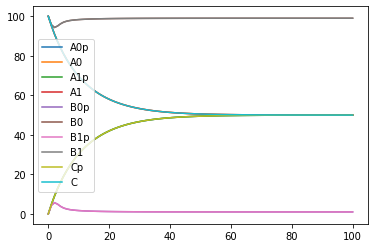

In [3]:
runner = roadrunner.RoadRunner(model.get_sbml_model())
res = runner.simulate(0, 100, 100)


states = model.get_state_variables().keys()
for s in states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)

plt.legend()
plt.show()

## Construst a more complex model based on rules

This script generates an arbitrarily large biochemical ODE system with the following limitations:
- A === B 
- Only 1 C specie
- No feedback regulations / crosstalk

In [4]:
R1 = Reaction(michaelis_menten, (specie+'p',), (specie,))
print(michaelis_menten.parameters_count)

2


In [ ]:
NA = 10
NB = 10
NC = 1
NR = 0

mean_range_species = (5, 500)
sd_range_species = (1, 100)

mean_range_params = (0.01, 1)
sd_range_params = (0.01, 1)

model = ModelBuilder('SimpleCascade2')

# based on the `NA` parameter, create a number of species for A

A_species = [f'A{i}' for i in range(NA)]
B_species = [f'B{i}' for i in range(NB)]
C_species = ['C']

# convert a list of species to a tuple of species
B_species_tuple_phos = []
for b in B_species:
    b_specie_phos = b + 'p'
    B_species_tuple_phos.append(b_specie_phos)
    
B_species_tuple_phos = tuple(B_species_tuple_phos)


for specie in A_species:
    # generate a random set of parameters for reaction A -> Ap
    r_params = []
    for i in range(michaelis_menten.parameters_count):
        rand = np.random.random()*mean_range_params[1]
        r_params.append(rand)
        
    # add the reaction Ap -> A to the model    
    model.add_reaction(Reaction(michaelis_menten, (specie+'p',), (specie,), 
                                parameters_values=tuple(r_params)))
    
    # generate a random initial value for A
    random_mean = np.random.randint(mean_range_species[0], mean_range_species[1])
    # generate a random set of parameters for reaction Ap -> A
    r_params_reverse = []
    for i in range(michaelis_menten.parameters_count):
        rand = np.random.random()*mean_range_params[1]
        r_params_reverse.append(rand)
        
    # add the reaction Ap -> A to the model    
    model.add_reaction(Reaction(michaelis_menten, (specie,), (specie+'p',), 
                                reactant_values=random_mean, 
                                parameters_values=tuple(r_params_reverse)))

for specie in B_species:
    # generate a random set of parameters for reaction B -> Bp
    r_params = []
    for i in range(michaelis_menten_stim.parameters_count):
        rand = np.random.random()*mean_range_params[1]
        r_params.append(rand)
    
    # add the reaction Bp -> B to the model
    model.add_reaction(Reaction(michaelis_menten_stim, (specie+'p',), (specie,), 
                                extra_states=('A'+specie[1]+'p',),
                                parameters_values=tuple(r_params)))
    
    # generate a random initial value for B
    random_mean = np.random.randint(mean_range_species[0], mean_range_species[1])
    
    # generate a random set of parameters for reaction B -> Bp
    r_params_reverse = []
    for i in range(michaelis_menten.parameters_count):
        rand = np.random.random()*mean_range_params[1]
        r_params_reverse.append(rand)
    
    # add the reaction B -> Bp to the model
    model.add_reaction(Reaction(michaelis_menten, (specie,), (specie+'p',), 
                                reactant_values=random_mean,
                                parameters_values=tuple(r_params_reverse)))
    

# randomise the number of stimulators and inhibitors for len(B_species) 

stimulator_number = np.random.randint(0, len(B_species))
inhibitor_number = len(B_species) - stimulator_number   

rate_law_C = create_archtype_michaelis_menten(stimulators=stimulator_number,
                                              stimulator_weak=0, 
                                              allosteric_inhibitors=inhibitor_number, 
                                              competitive_inhibitors=0)    
    
for specie in C_species:
    model.add_reaction(Reaction(rate_law_C, (specie+'p',), (specie,), extra_states=B_species_tuple_phos))
    model.add_reaction(Reaction(michaelis_menten, (specie,), (specie+'p',)))
    
# add stimulation reactions

print(model.get_antimony_model())

model SimpleCascade2

J0: A0p -> A0; J0_Vmax*A0p/(J0_Km + A0p)
J1: A0 -> A0p; J1_Vmax*A0/(J1_Km + A0)
J2: A1p -> A1; J2_Vmax*A1p/(J2_Km + A1p)
J3: A1 -> A1p; J3_Vmax*A1/(J3_Km + A1)
J4: A2p -> A2; J4_Vmax*A2p/(J4_Km + A2p)
J5: A2 -> A2p; J5_Vmax*A2/(J5_Km + A2)
J6: A3p -> A3; J6_Vmax*A3p/(J6_Km + A3p)
J7: A3 -> A3p; J7_Vmax*A3/(J7_Km + A3)
J8: A4p -> A4; J8_Vmax*A4p/(J8_Km + A4p)
J9: A4 -> A4p; J9_Vmax*A4/(J9_Km + A4)
J10: A5p -> A5; J10_Vmax*A5p/(J10_Km + A5p)
J11: A5 -> A5p; J11_Vmax*A5/(J11_Km + A5)
J12: A6p -> A6; J12_Vmax*A6p/(J12_Km + A6p)
J13: A6 -> A6p; J13_Vmax*A6/(J13_Km + A6)
J14: A7p -> A7; J14_Vmax*A7p/(J14_Km + A7p)
J15: A7 -> A7p; J15_Vmax*A7/(J15_Km + A7)
J16: A8p -> A8; J16_Vmax*A8p/(J16_Km + A8p)
J17: A8 -> A8p; J17_Vmax*A8/(J17_Km + A8)
J18: A9p -> A9; J18_Vmax*A9p/(J18_Km + A9p)
J19: A9 -> A9p; J19_Vmax*A9/(J19_Km + A9)
J20: B0p -> B0; J20_Vmax*B0p*A0p/(J20_Km + B0p)
J21: B0 -> B0p; J21_Vmax*B0/(J21_Km + B0)
J22: B1p -> B1; J22_Vmax*B1p*A1p/(J22_Km + B1p)
J23: B1 ->

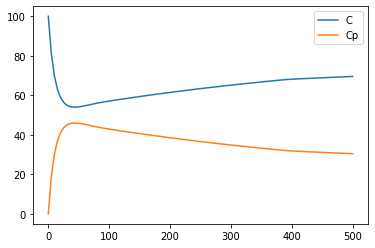

In [6]:
runner = roadrunner.RoadRunner(model.get_sbml_model())
res = runner.simulate(0, 500, 100)


states = model.get_state_variables().keys()

visible_states = ['C', 'Cp']

for s in visible_states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)

plt.legend()
plt.show()

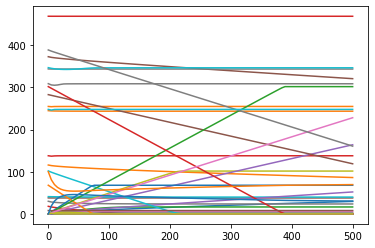

In [7]:
runner = roadrunner.RoadRunner(model.get_sbml_model())
res = runner.simulate(0, 500, 100)


states = model.get_state_variables().keys()

visible_states = ['C', 'Cp']

for s in states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)

# plt.legend()
plt.show()

## Complex model with feedback 
- to use the NR parameter and generate random crosstalks

### Construction

In [109]:
NA = 3
NR = 3

mean_range_species = (5, 5000)
rangeScale_params = (0.2, 5)
rangeMultiplier_params = (0.1, 2)

model = ModelBuilder('FeedbackRegulationTwoLayerCascade')

# based on the `NA` parameter, create a number of species for A

A_species = [f'A{i}' for i in range(NA)]
B_species = [f'B{i}' for i in range(NA)]
C_species = ['C']

# based on the number of NR, create random connections between any two species in the network
regulation_types_choice = ['up', 'down']
regulations = []
reg_types = []

all_species = A_species + B_species + C_species
B_and_C = B_species + C_species

# max attempts is the permutation of specie C and B * 100
max_attempt = len(B_and_C)**2 * 100
current_attempt = 0
while len(regulations) < NR and current_attempt < max_attempt:
    from_specie = np.random.choice(B_and_C)
    to_specie = np.random.choice(all_species)
    reg = (from_specie, to_specie)
    reverse_reg = (to_specie, from_specie)
    
    # also exclude self-regulations and B -> C regulations
    if from_specie == to_specie or (from_specie in B_species and to_specie in C_species):
        continue
    
    if reg not in regulations and reverse_reg not in regulations:
        reg_type = np.random.choice(regulation_types_choice)
        regulations.append(reg)
        reg_types.append(reg_type)
        

if current_attempt == max_attempt:
    print('Failed to generate the network in the given number of attempts, max attempt:', max_attempt)
    exit(1)
    
# finally, each Ap index affects every B -> Bp reaction index
for i in range(NA):
    regulations.append((f'A{i}', f'B{i}'))
    reg_types.append('up')

for i, reg in enumerate(regulations):
    print(f'Regulation {i}: {reg} - {reg_types[i]}')

def generate_archtype_and_regulators(all_regulations, all_regulation_types):
    
    regulators_for_specie = []
    for i, reg in enumerate(all_regulations):
        if reg[1] == specie:
            reg_type = all_regulation_types[i]
            regulators_for_specie.append((reg[0], reg_type))

    if len(regulators_for_specie) == 0:
        return michaelis_menten, ()

    total_up_regulations = len([r for r in regulators_for_specie if r[1] == 'up'])
    total_down_regulations = len([r for r in regulators_for_specie if r[1] == 'down'])

    rate_law = create_archtype_michaelis_menten(stimulators=total_up_regulations,
                                                stimulator_weak=0,
                                                allosteric_inhibitors=total_down_regulations,
                                                competitive_inhibitors=0)
    
    # sort the regulators by type, up first and down second
    regulators_for_specie = sorted(regulators_for_specie, key=lambda x: x[1], reverse=True)
    regulators_sorted = [r[0] for r in regulators_for_specie]
    regulators_sorted_phos = [r[0]+'p' for r in regulators_for_specie]

    # print(f'Sorted regulators information: {regulators_for_specie}')
    # print(f'Final regulators for {specie}: {regulators_sorted_phos}')
    # print(f'Rate law for {specie}: {rate_law}')
    
    return rate_law, regulators_sorted_phos


# generate random parameters informed by a scale 
def generate_random_parameters(reaction_archtype: ReactionArchtype, scale_range, multiplier_range):
    
    assumed_values = reaction_archtype.assume_parameters_values
    # print(f'Assumed values: {assumed_values}')
    r_params = []
    for key, value in assumed_values.items():
        rand = np.random.uniform(value*scale_range[0], value*scale_range[1])
        rand *= np.random.uniform(multiplier_range[0], multiplier_range[1])
        r_params.append(rand)
    
    return tuple(r_params)

# convert a list of species to a tuple of species
B_species_tuple_phos = []
for b in B_species:
    b_specie_phos = b + 'p'
    B_species_tuple_phos.append(b_specie_phos)
    
B_species_tuple_phos = tuple(B_species_tuple_phos)




'''A Specie reactions'''

for specie in A_species:
    
    # create the rate law for the specie
    rate_law, regulators = generate_archtype_and_regulators(regulations, reg_types)
            
    
    # generate a random set of parameters for reaction A -> Ap
    r_params = generate_random_parameters(michaelis_menten, rangeScale_params, rangeMultiplier_params)
        
    # add the reaction Ap -> A to the model    
    model.add_reaction(Reaction(michaelis_menten, (specie+'p',), (specie,), 
                                parameters_values=tuple(r_params)))
    
    # generate a random initial value for A
    random_mean = np.random.randint(mean_range_species[0], mean_range_species[1])
    # generate a random set of parameters for reaction Ap -> A
    r_params_reverse = generate_random_parameters(rate_law, rangeScale_params, rangeMultiplier_params)
        
    # add the reaction Ap -> A to the model    
    model.add_reaction(Reaction(rate_law, (specie,), (specie+'p',), 
                                reactant_values=random_mean, 
                                extra_states=regulators,
                                parameters_values=tuple(r_params_reverse)))

'''B Specie reactions'''

for specie in B_species:
    # create the rate law for the specie
    rate_law, regulators = generate_archtype_and_regulators(regulations, reg_types)
    
    # generate a random set of parameters for reaction B -> Bp
    r_params = generate_random_parameters(michaelis_menten, rangeScale_params, rangeMultiplier_params)
    
    # add the reaction Bp -> B to the model
    model.add_reaction(Reaction(michaelis_menten, (specie+'p',), (specie,), 
                                parameters_values=tuple(r_params)))
    
    # generate a random initial value for B
    random_mean = np.random.randint(mean_range_species[0], mean_range_species[1])
    
    # generate a random set of parameters for reaction B -> Bp
    r_params_reverse = generate_random_parameters(rate_law, rangeScale_params, rangeMultiplier_params)
    
    # add the reaction B -> Bp to the model
    model.add_reaction(Reaction(rate_law, (specie,), (specie+'p',), 
                                reactant_values=random_mean,
                                extra_states=regulators,
                                parameters_values=tuple(r_params_reverse)))
    

'''C Specie reactions'''
# randomise the number of stimulators and inhibitors for len(B_species) 

stimulator_number = np.random.randint(0, len(B_species))
inhibitor_number = len(B_species) - stimulator_number 
print(f'Stimulators: {stimulator_number}, Inhibitors: {inhibitor_number}')  

rate_law_C = create_archtype_michaelis_menten(stimulators=stimulator_number,
                                              stimulator_weak=0, 
                                              allosteric_inhibitors=inhibitor_number, 
                                              competitive_inhibitors=0)    

newReaction = Reaction(rate_law_C, (specie+'p',), (specie,), extra_states=B_species_tuple_phos)

for specie in C_species:
    model.add_reaction(Reaction(rate_law_C, (specie,), (specie+'p',), extra_states=B_species_tuple_phos))
    model.add_reaction(Reaction(michaelis_menten, (specie+'p',), (specie,), reactant_values=0, product_values=100))
    
# add stimulation reactions

print('\n')
print('--- Antimony Model ---')
print('\n')
print(model.get_antimony_model())
print('\n')
print('Model States: ', len(model.states))
print('Model Parameters: ', len(model.parameters))
print('Model Reactions: ', len(model.reactions))

Regulation 0: ('B2', 'B0') - down
Regulation 1: ('B2', 'A1') - up
Regulation 2: ('B1', 'A0') - down
Regulation 3: ('A0', 'B0') - up
Regulation 4: ('A1', 'B1') - up
Regulation 5: ('A2', 'B2') - up
Stimulators: 1, Inhibitors: 2


--- Antimony Model ---


model FeedbackRegulationTwoLayerCascade

J0: A0p -> A0; J0_Vmax*A0p/(J0_Km + A0p)
J1: A0 -> A0p; J1_Vmax*A0/(J1_Km + A0)*(1+B1p*J1_Kil0)
J2: A1p -> A1; J2_Vmax*A1p/(J2_Km + A1p)
J3: A1 -> A1p; J3_Vmax*A1*(B2p*J3_Ka0)/(J3_Km + A1)
J4: A2p -> A2; J4_Vmax*A2p/(J4_Km + A2p)
J5: A2 -> A2p; J5_Vmax*A2/(J5_Km + A2)
J6: B0p -> B0; J6_Vmax*B0p/(J6_Km + B0p)
J7: B0 -> B0p; J7_Vmax*B0*(A0p*J7_Ka0)/(J7_Km + B0)*(1+B2p*J7_Kil0)
J8: B1p -> B1; J8_Vmax*B1p/(J8_Km + B1p)
J9: B1 -> B1p; J9_Vmax*B1*(A1p*J9_Ka0)/(J9_Km + B1)
J10: B2p -> B2; J10_Vmax*B2p/(J10_Km + B2p)
J11: B2 -> B2p; J11_Vmax*B2*(A2p*J11_Ka0)/(J11_Km + B2)
J12: C -> Cp; J12_Vmax*C*(B0p*J12_Ka0)/(J12_Km + C)*(1+B1p*J12_Kil0+B2p*J12_Kil1)
J13: Cp -> C; J13_Vmax*Cp/(J13_Km + Cp)

# State vari

### Simulation and visualisation

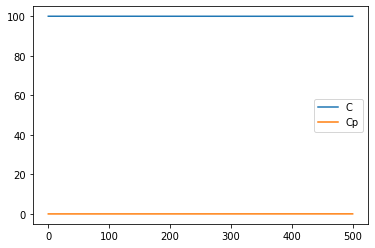

In [118]:
runner = roadrunner.RoadRunner(model.get_sbml_model())
res = runner.simulate(0, 500, 100)


states = model.get_state_variables().keys()

visible_states = ['C', 'Cp']

for s in visible_states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)

plt.legend()
plt.show()

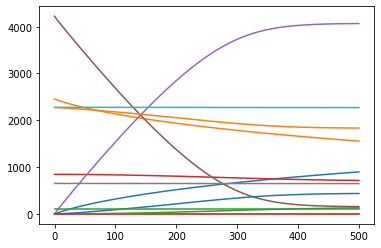

In [119]:
for s in states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)

# plt.legend()
plt.show()

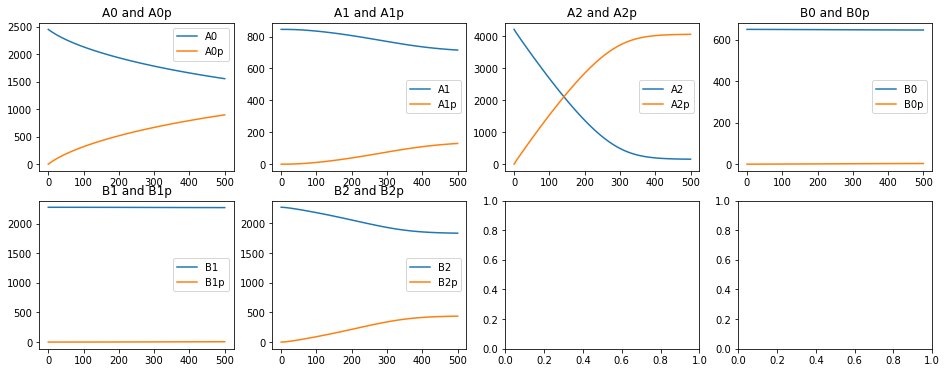

In [120]:
# make a multi-plot of the species, for each individual plot, show the species and the phosphorylated species

# use multiple subplots to show the species and the phosphorylated species for A and B
# ensure that the phosphorylated species are shown in the same plot as the original species

# create a subplot for each species, display 4 species per row
AandB = A_species + B_species
columns = 4
fig, axs = plt.subplots(len(AandB)//columns+1, columns, figsize=(4*columns, 4*len(AandB)//columns))

for i, specie in enumerate(AandB):
    row = i // columns
    col = i % columns
    
    # get the phosphorylated specie
    specie_phos = specie + 'p'
    
    # plot the specie
    axs[row, col].plot(res['time'], res[f'[{specie}]'], label=specie)
    axs[row, col].plot(res['time'], res[f'[{specie_phos}]'], label=specie_phos)
    axs[row, col].set_title(f'{specie} and {specie_phos}')
    axs[row, col].legend()
    
plt.show()


     

### Generation of Synthetic Data 

By perturbing the model using sampling methods, a sample dataset is generated, where feature data is the initial values of A and the target being the value of C at a time threshold 

In [113]:
## Perturbation sampling parameters
perturbationScale_range = (0.1, 10) # each parameter is perturbed by a random value between 0.1 and 10
num_pertrubations = 2000


# grab the initial values of all A species
initial_values = {}
for s in A_species:
    initial_values[s] = runner.getValue(f'init({s})')
    # print(s, runner[s])

all_perturbed_values = []
for i in range(num_pertrubations):
    perturbed_values = {}
    for s in A_species:
        perturbed_values[s] = initial_values[s] * np.random.uniform(perturbationScale_range[0], perturbationScale_range[1])
    
    all_perturbed_values.append(perturbed_values)
    
# put the perturbed values into a dataframe
feature_df = pd.DataFrame(all_perturbed_values)
feature_df.head()
    
    
    


,A0,A1,A2
0,23363.933222,2955.634569,6693.848511
1,10464.849313,5770.545904,37703.230545
2,8975.581214,8193.697534,3967.073064
3,7461.823779,7255.712162,37171.847360
4,20547.638639,7937.422411,14712.576699


In [114]:
# iterate the dataframe and simulate each perturbation
all_perturbed_results = []

for i in range(feature_df.shape[0]):
    # Reset rr model and simulate with each perturbation
    runner.reset()
    perturbed_values = feature_df.iloc[i]

    # set the perturbed values
    for s in A_species:
        runner[f'init({s})'] = perturbed_values[s]

    # simulate the model and grab only the C and Cp values at the end
    res = runner.simulate(0, 500, 100)
    perturbed_results = {}
    for c in C_species:
        perturbed_results[f'{c}p'] = runner.getValue(f'{c}p')
    all_perturbed_results.append(perturbed_results)
    
target_df = pd.DataFrame(all_perturbed_results)
target_df.head()
        

,Cp
0,0.065327
1,0.124715
2,0.026155
3,0.121073
4,0.113563


### Generation of sub-optimal estimated models 

If the first generated model is treated as the ground truth model S0 (i.e. the true reality of cell signalling), sub-optimal models, S1, S2... are generated as estimates of the ground truth

## Testing

In [28]:
import pickle 

# load a model from a file
path = 'models\examples\InterestingSmallModel.pkl'

with open(path, 'rb') as f:
    model = pickle.load(f)
    
print(model.get_antimony_model())

model FeedbackRegulationTwoLayerCascade

J0: A0p -> A0; J0_Vmax*A0p/(J0_Km + A0p)
J1: A0 -> A0p; J1_Vmax*A0/(J1_Km + A0)
J2: A1p -> A1; J2_Vmax*A1p/(J2_Km + A1p)
J3: A1 -> A1p; J3_Vmax*A1/(J3_Km + A1)
J4: B0p -> B0; J4_Vmax*B0p/(J4_Km + B0p)
J5: B0 -> B0p; J5_Vmax*B0*(B1p*J5_Ka0+A0p*J5_Ka1)/(J5_Km + B0)
J6: B1p -> B1; J6_Vmax*B1p/(J6_Km + B1p)
J7: B1 -> B1p; J7_Vmax*B1*(A1p*J7_Ka0)/(J7_Km + B1)
J8: Cp -> C; J8_Vmax*Cp/(J8_Km + Cp)*(1+B0p*J8_Kil0+B1p*J8_Kil1)
J9: C -> Cp; J9_Vmax*C/(J9_Km + C)

# State variables in the system
A0p=0
A0=401
A1p=0
A1=368
B0p=0
B0=217
B1p=0
B1=82
Cp=0
C=100

# Parameters in the system
J0_Km=0.11308826937964322
J0_Vmax=0.10423104330018418
J1_Km=0.36111165521658894
J1_Vmax=0.6625570773015934
J2_Km=0.2836910939087057
J2_Vmax=0.9571689212989276
J3_Km=0.9745409005613707
J3_Vmax=0.25138528373951285
J4_Km=0.4577479785335925
J4_Vmax=0.9306779909751701
J5_Km=0.10005787370788854
J5_Vmax=0.3271690786422303
J5_Ka0=0.3932672538669342
J5_Ka1=0.20320769949484951
J6_Km=0.4

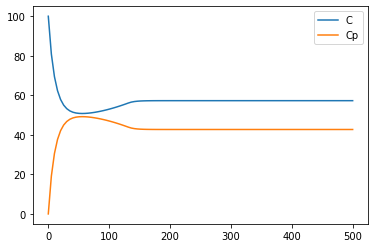

In [29]:
runner = roadrunner.RoadRunner(model.get_sbml_model())
res = runner.simulate(0, 500, 100)


states = model.get_state_variables().keys()

visible_states = ['C', 'Cp']

for s in visible_states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)

plt.legend()
plt.show()